<a href="https://colab.research.google.com/github/jenny005/Langgraph-Tutorial/blob/main/Copy_of_06_chatbot_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Messages Summarization
![Chain](https://github.com/esurovtsev/langgraph-intro/blob/main/images/summarization.png?raw=1)

In [1]:
pip install -r /content/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/1

In [1]:
from dotenv import load_dotenv  # load environment variables from a .env file into your program’s os.environ dictionary
load_dotenv("/content/.env", override=True)

True

## "Standard" chatbot

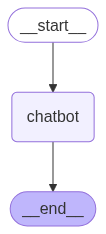

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# OPENAI_API_KEY environment variable must be set
llm = ChatOpenAI(model="gpt-4o-mini")

# Defining Schema
##################################################################################
class State(MessagesState):
    question: str
    answer: str


# Defining Agent's node
##################################################################################

# System message
chatbot_system_message = SystemMessage(content=("""
You are a helpful and knowledgeable chatbot assistant.
Your goal is to provide clear and accurate answers to user questions based on the information they provide.
Stay focused, concise, and ensure your responses are relevant to the context of the conversation.
If you don’t have enough information, ask for clarification.”
"""))

# Node
def chatbot(state: State) -> State:
    question = HumanMessage(content=state.get("question", ""))
    response = llm.invoke([chatbot_system_message] + state["messages"] + [question]);

    return State(
        messages = [question, response],
        question = state.get("question", None),
        answer = response.content
    )


# Defining Graph
##################################################################################

builder = StateGraph(State)
builder.add_node("chatbot", chatbot)


# Define edges: these determine how the control flow moves
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

memory = MemorySaver()
chatbot_graph = builder.compile(checkpointer=memory)

# Show
display(Image(chatbot_graph.get_graph(xray=True).draw_mermaid_png()))

## Removing messages

1) we use MessagesState
2) MessageState has a built-in list of messages ("messages" key)
3) Key "messages" has a built-in reducer "add_messages"

In [6]:
from typing import Annotated
from typing import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [7]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph.message import add_messages

messages = [
    HumanMessage(content="Message 1", id="1"),
    AIMessage(content="Message 2", id="2"),
    HumanMessage(content="Message 3", id="3"),
    AIMessage(content="Message 4", id="4"),
    HumanMessage(content="Message 5", id="5"),
    AIMessage(content="Message 6", id="6")
]

new_message = HumanMessage(content="Message 7", id="7")

# Test
messages = add_messages(messages , new_message)
messages

[HumanMessage(content='Message 1', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='Message 2', additional_kwargs={}, response_metadata={}, id='2'),
 HumanMessage(content='Message 3', additional_kwargs={}, response_metadata={}, id='3'),
 AIMessage(content='Message 4', additional_kwargs={}, response_metadata={}, id='4'),
 HumanMessage(content='Message 5', additional_kwargs={}, response_metadata={}, id='5'),
 AIMessage(content='Message 6', additional_kwargs={}, response_metadata={}, id='6'),
 HumanMessage(content='Message 7', additional_kwargs={}, response_metadata={}, id='7')]

In [8]:
from langchain_core.messages import RemoveMessage

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
delete_messages

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='3'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='4'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='5')]

In [9]:
messages = add_messages(messages , delete_messages)
messages

[AIMessage(content='Message 6', additional_kwargs={}, response_metadata={}, id='6'),
 HumanMessage(content='Message 7', additional_kwargs={}, response_metadata={}, id='7')]

## Summarization chatbot

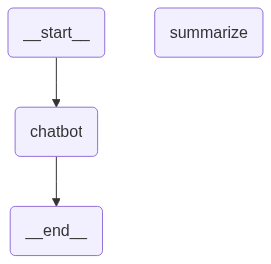

In [10]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

# Defining Schema
##################################################################################
class SummaryState(State):
    summary: str

# Nodes
def chatbot(state: SummaryState) -> SummaryState:
    summary = state.get("summary", "") # getting summary if it exists

    # If there is summary, then we add it
    if summary:
        # define summary as SystemMessage
        summary_message = SystemMessage(content=(f"""
        Summary of Conversation:

        {summary}
        """))

        messages_with_summary = [summary_message] + state["messages"]

    else:
        messages_with_summary = state["messages"]


    question = HumanMessage(content=state.get("question", ""))

    response = llm.invoke([chatbot_system_message] + messages_with_summary + [question]);

    return SummaryState(
        messages = [question, response],
        question = state.get("question", None),
        answer = response.content,
        summary = state.get("summary", None)
    )


def summarize(state: SummaryState) -> SummaryState:
    summary = state.get("summary", "")
    # no system message
    # the order of components is important

    if summary:
        summary_message = HumanMessage(content=(f"""
            Expand the summary below by incorporating the above conversation while preserving context, key points, and
            user intent. Rework the summary if needed. Ensure that no critical information is lost and that the
            conversation can continue naturally without gaps. Keep the summary concise yet informative, removing
            unnecessary repetition while maintaining clarity.

            Only return the updated summary. Do not add explanations, section headers, or extra commentary.

            Existing summary:

            {summary}
            """)
        )

    else:
        summary_message = HumanMessage(content="""
        Summarize the above conversation while preserving full context, key points, and user intent. Your response
        should be concise yet detailed enough to ensure seamless continuation of the discussion. Avoid redundancy,
        maintain clarity, and retain all necessary details for future exchanges.

        Only return the summarized content. Do not add explanations, section headers, or extra commentary.
        """)

    # Add prompt to our history
    messages = state["messages"] + [summary_message]
    response = llm.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return SummaryState(
        messages = delete_messages,
        question = state.get("question", None),
        answer = state.get("answer", None),
        summary = response.content
    )


# Edges

# Determine whether to end or summarize the conversation
def should_summarize(state: SummaryState):
    messages = state["messages"]

    if len(messages) > 2:
        return "summarize"

    return END


# Graph
workflow = StateGraph(SummaryState)
workflow.add_node(chatbot)
workflow.add_node(summarize)

workflow.add_edge(START, "chatbot")
workflow.add_conditional_edges("chatbot", should_summarize)
workflow.add_edge("summarize", END)


memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
thread_id = "1"
config = {"configurable": {"thread_id": thread_id}}

graph.invoke(State(question="Hi, I’m working on a Python project, and I’m stuck with handling API responses."), config)

{'messages': [HumanMessage(content='Hi, I’m working on a Python project, and I’m stuck with handling API responses.', additional_kwargs={}, response_metadata={}, id='0c7a8c01-2977-4cf0-a5e1-4b53051c3cd6'),
  AIMessage(content='I’d be happy to help! What specific issues are you facing with API responses in your Python project? Are you having trouble with making requests, parsing the responses, or something else?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 89, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C4pJ6aNFT88hiJ4hLgFcPlbS2kFs7', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--554c6450-d333-4a5f-8efb-9e2c616

In [12]:
graph.invoke(State(question="Sorry what was my previous question?"), config)

{'messages': [HumanMessage(content='Sorry what was my previous question?', additional_kwargs={}, response_metadata={}, id='62e5c8e6-0819-448a-8641-a66002a1dd15'),
  AIMessage(content='You mentioned that you were working on a Python project and were stuck with handling API responses. How can I assist you further with that?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 141, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C4pJGXOtz4JXBeTXrmwJlcQFJlTgH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0b29a789-1e19-4771-b413-6aaa10b6f786-0', usage_metadata={'input_tokens': 141, 'output_tokens': 27, 'total_tokens': 168, '

In [13]:
graph.invoke(State(question="Ahh, yeah right! So I’m mostly struggling with parsing JSON responses. Sometimes the structure isn’t what I expect, and it breaks my code."), config)

{'messages': [HumanMessage(content='Ahh, yeah right! So I’m mostly struggling with parsing JSON responses. Sometimes the structure isn’t what I expect, and it breaks my code.', additional_kwargs={}, response_metadata={}, id='6faba062-2dc2-4883-a3d7-cdd9a0d00249'),
  AIMessage(content='I understand. Parsing JSON can be tricky, especially if the structure varies. Here are a few tips to handle unexpected JSON structures:\n\n1. **Use `try-except` Blocks**: Wrap your parsing code in `try-except` blocks to handle exceptions gracefully when the structure isn\'t as expected.\n\n   ```python\n   import json\n\n   response = \'{"key": "value"}\'  # Example response\n   try:\n       data = json.loads(response)\n       print(data[\'expected_key\'])\n   except KeyError:\n       print("Expected key not found in the response.")\n   except json.JSONDecodeError:\n       print("Failed to decode JSON.")\n   ```\n\n2. **Check Structure Before Accessing**: Before accessing nested keys, check if they exist.

In [14]:
graph.invoke(State(question="Got it! That helps a lot. What would be the best way to handle deeply nested JSON data when I only need a few specific values?"), config)

{'messages': [HumanMessage(content='Got it! That helps a lot. What would be the best way to handle deeply nested JSON data when I only need a few specific values?', additional_kwargs={}, response_metadata={}, id='47fc65ec-9911-4632-b0aa-1d7a205dc2c7'),
  AIMessage(content="When dealing with deeply nested JSON data, and you only need a few specific values, it's best to navigate through the structure carefully to avoid breaking your code. Here are some strategies to effectively handle such cases:\n\n1. **Use a Recursive Function**: If the nesting is unpredictable, you can create a recursive function to traverse the JSON tree and extract the values you're interested in.\n\n   ```python\n   def find_values(data, keys):\n       if isinstance(data, dict):\n           for key in keys:\n               if key in data:\n                   yield data[key]\n           for value in data.values():\n               yield from find_values(value, keys)\n       elif isinstance(data, list):\n           fo

In [15]:
graph.invoke(State(question="How is the weather outside?"), config)

{'messages': [HumanMessage(content='How is the weather outside?', additional_kwargs={}, response_metadata={}, id='90b18464-fb93-465d-b44d-930fc4a6221f'),
  AIMessage(content="I'm unable to provide real-time information, such as current weather conditions. However, you can check the weather using a weather website, app, or by calling an API service like OpenWeatherMap or WeatherAPI to get up-to-date information. If you need help with how to fetch weather data using Python or an API, let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 739, 'total_tokens': 807, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C4pKAe1lhgHEWiqhPHYER35JCgIpc', 'service_tier': 'default'